## Task 2 - Implement Word2vec 25 Marks
You are tasked with building a pipeline for training a Word2Vec model using the CBOW (Continuous Bag
of Words) approach FROM SCRATCH in PyTorch. It consist of the following components:

1. You are required to create a Python class named Word2VecDataset that will serve as a custom dataset
for training the Word2Vec model. The implementaion should include the following components:

    - The custom implementation should work with PyTorch’s DataLoader to efficiently load the train-
ing data.. You can refer this guide [Tutorial] on creating custom dataset classes in PyTroch.

    - preprocess data - In this method, you will be preprocessing the provided corpus and prepare
the CBOW training data for training the Word2Vec model.

    - During preprocessing, you must use the WordPieceTokenizer implemented in Task 1 to tokenize
the input text corpus.

2. You required to create a Python class named Word2VecModel which implement Word2Vec CBOW
architecture from scratch using PyTorch. After training the the model, save the trained model’s
checkpoint for later use.

3. Develop a function named train to manage the entire training process of the Word2Vec model. This
function should include all the training logic.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json
import os
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm

import sys
import os


In [3]:
sys.path.append(os.path.abspath('../Task 1'))

print(os.getcwd())

# changing directories to get the WordPieceTokenizer class from task1
os.chdir('../Task1')

print(os.getcwd())

from task1 import WordPieceTokenizer

tokenizer = WordPieceTokenizer()

os.chdir('../Task2')

print(os.getcwd())


c:\Users\ISHITA\OneDrive\Desktop\CSAM6\NLP\Assignments\Assignment 1\CSE556-NLP\assignment1\Task2
c:\Users\ISHITA\OneDrive\Desktop\CSAM6\NLP\Assignments\Assignment 1\CSE556-NLP\assignment1\Task1
c:\Users\ISHITA\OneDrive\Desktop\CSAM6\NLP\Assignments\Assignment 1\CSE556-NLP\assignment1\Task2


## Word2VecDataset Class

In [4]:
# Word2VecDataset(Dataset) => inherits from the Dataset class of Pytorch
class Word2VecDataset(Dataset):
    
    def __init__(self, window_size, vocabulary_size):
        
        """
        text : input corput as string
        window size : defines how many words to take on either side as context
        pad token : a special token used for padding in case of insufficient context
        """

        self.pad_token = '[PAD]'
        self.window_size = window_size
        self.tokenizer = WordPieceTokenizer()
        self.vocabulary_size = vocabulary_size

        self.text = None

        # stores unique words in the corpus
        self.vocabulary = None
        # a dictionary mapping words to indices
        self.word_to_idx = None
        # a dictionary mapping indices to words
        self.idx_to_word = None
        # a list that will store training pairs
        self.cbow_pairs = []
        
        self.preprocess_data()

    # uses Word Piece Tokenizer from Task 1 to tokenize input corpus
    def tokenize_txt_file(self, input_file, output_file):
        
        with open(input_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        results = {}
        
        for idx, line in lines:
            sentence = line.strip() 
            tokens = self.tokenizer.tokenize(sentence)
            results[str(idx)] = tokens 

        
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2)

    

    def update_vocabulary(self):

        self.tokenizer.construct_vocabulary("corpus.txt", vocab_size=self.vocabulary_size)

        vocabulary = []

        with open('vocabulary_35.txt', 'r') as file:
            
            for line in file:
                word = line.strip()
                if word:  # to avoid adding empty lines
                    vocabulary.append(word)

        self.vocabulary = vocabulary
        print("got and updated vocab")

    
    def tokenize_corpus(self):
        
        self.tokenize_txt_file("corpus.txt", "tokenized_corpus.json")

        corpus = None

        with open('tokenized_corpus.json', 'r', encoding='utf-8') as f:

            tokenized_corpus = json.load(f)
            # convert to list
            corpus = [tokens for tokens in tokenized_corpus.values()]
            
        
        self.text = corpus


    def generate_cbow_pairs(self):

        # looping over tokenized corpus
        for sentence in self.text:

            for j in range(len(sentence)):

                #context words
                context_words = (sentence[max(0, j - self.window_size):j] + 
                                sentence[j + 1:min(len(sentence), j + self.window_size + 1)])
                
                
                if len(context_words) > 0:

                    # pad if needed
                    while len(context_words) < self.window_size * 2:
                        context_words.append(self.pad_token)
                    
                    # get indices for context words
                    context_idxs = [self.word_to_idx.get(w, self.word_to_idx[self.pad_token]) for w in context_words]
                    # get index for target word
                    target_idx = self.word_to_idx.get(sentence[j], self.word_to_idx[self.pad_token])
                    
                    # store pair
                    self.cbow_pairs.append((context_idxs, target_idx))


    # function to tokenize text, creates the vocabulary and generates CBOW training pairs
    def preprocess_data(self):

        print("updating vocabulary")     
        self.update_vocabulary()

        print("tokenizing corpus")
        self.tokenize_corpus()

        print("updating mapping - word2idx and idx2word")

        # updates the word to index mapping
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocabulary)}
        # updates the reverse index to word mapping
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        

        print("generating cbow pairs")
        self.generate_cbow_pairs()
    
    # returns the total number of CBOW training pairs
    def __len__(self):
        return len(self.cbow_pairs)
    
    
    # used to retrieve a single CBOW pair (context, target) pair
    def __getitem__(self, idx):

        # get the pair of ith index as mentioned parameter 
        context_indices, target_idx = self.cbow_pairs[idx]
        
        # Convert to tensors with explicit types
        context_tensor = torch.tensor(context_indices, dtype=torch.long)
        target_tensor = torch.tensor(target_idx, dtype=torch.long)
        
        return context_tensor, target_tensor



## Word2VecModel class

In [5]:
# Word2VecModel(nn.Module) => Inherits from nn.Module class in Pytorch
class Word2VecModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        
        '''
        vocab size : the size of the vocabulary
        embedding dimension : the number of features that represent each word
        '''

        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # creates a special table that stores word representations for each word
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        

        self._initialize_weights()
    
    # function to initialize weight
    def _initialize_weights(self):
        
        # range of weights
        initrange = 0.5 / self.embedding_dim
        
        # initializing embedding layer
        self.embeddings.weight.data.uniform_(-initrange, initrange)
        
        # initializing output layer
        self.output_layer.weight.data.uniform_(-initrange, initrange)

        # initializing the bias of output layer
        self.output_layer.bias.data.zero_()
    

    # function for forward pass of the model
    def forward(self, x: torch.Tensor):

        """
        x : input tensor, which represents the indices of the context words in the vocabulary. Its shape is [batch size, window size*2] -- [target word, [list of indexes of context words]]
        """

        # will look up for embeddings for each word in context and output list of embeddings of each congext word
        # size = [batch size, window size*2, embedding dimension]
        embedded = self.embeddings(x)
        
        # calculates average of context words... horizontally - row by row
        # size = [batch_size, embedding_dim]
        context_embedding = torch.mean(embedded, dim=1)
        
        # passing the average context embedding to output layer
        # output size vector = [batch_size, vocab_size]
        output = self.output_layer(context_embedding)

        # returning after application of softmax function
        return F.log_softmax(output, dim=1)

    
    # get embedding vector for a word
    def get_word_vector(self, word_idx):

        return self.embeddings.weight.data[word_idx]
    
    def cosine_similarity(self, word_idx1, word_idx2):

        vec1 = self.get_word_vector(word_idx1)
        vec2 = self.get_word_vector(word_idx2)
        
        return F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()
    
    def find_most_similar(self, word_idx, top_k):

        target_vector = self.get_word_vector(word_idx)
        
        # calculating similarities with all words
        similarities = F.cosine_similarity(
            target_vector.unsqueeze(0),
            self.embeddings.weight.data
        )
        
        similarities[word_idx] = -1  # to exclude the word itself
        top_scores, top_indices = similarities.topk(top_k)
        
        return list(zip(top_indices.tolist(), top_scores.tolist()))
    
    def find_least_similar(self, word_idx):
 
        target_vector = self.get_word_vector(word_idx)
        
        # calculating similarities with all words
        similarities = F.cosine_similarity(
            target_vector.unsqueeze(0),
            self.embeddings.weight.data
        )
        
        
        similarities[word_idx] = 1  # exclude the word itself
        min_score, min_idx = similarities.min(dim=0)
        
        return (min_idx.item(), min_score.item())

## Functions for saving and loading checkpoints

In [6]:
def save_checkpoint(model, checkpoint_path, epoch, optimizer, loss, accuracy):

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
        'vocab_size': model.vocab_size,
        'embedding_dim': model.embedding_dim,
        'timestamp': datetime.now().isoformat()
    }
    torch.save(checkpoint, checkpoint_path)


def load_checkpoint(model, checkpoint_path, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):

    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    return {
        'model': model,
        'optimizer_state_dict': checkpoint['optimizer_state_dict'],
        'epoch': checkpoint['epoch'],
        'loss': checkpoint['loss'], 
        'accuracy': checkpoint['accuracy'], 
        'vocab_size': checkpoint['vocab_size'],
        'embedding_dim': checkpoint['embedding_dim'],
        'timestamp': checkpoint['timestamp']
    }

## Training Function

In [32]:
def train_word2vec(model,train_loader,val_loader,num_epochs,learning_rate,
    checkpoint_dir = 'checkpoints',
    save_frequency = 5,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
):
    
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    history = {
        'epoch_losses': [],
        'epoch_accuracies': [],
        'batch_losses': [],
        'batch_accuracies': [],
        'val_losses':[],
        'val_accuracies':[],
        'val_similarities':[]
    }
    
    for epoch in range(num_epochs):
        # Compute decayed learning rate
        current_lr = learning_rate * (1 - epoch / num_epochs)
        # current_lr = learning_rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
        
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        num_batches = len(train_loader)
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        model.train()

        for batch_idx, (context, target) in enumerate(progress_bar):
            context, target = context.to(device), target.to(device)
            optimizer.zero_grad()
            output = model.forward(context)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            predicted = output.argmax(dim=1)
            correct = (predicted == target).sum().item()
            total = target.size(0)
            
            batch_accuracy = (correct / total) * 100
            batch_loss = loss.item()
            epoch_loss += batch_loss
            epoch_correct += correct
            epoch_total += total
            
            history['batch_losses'].append(batch_loss)
            history['batch_accuracies'].append(batch_accuracy)
            
            progress_bar.set_postfix({
                'batch_loss': f'{batch_loss:.4f}',
                'batch_acc': f'{batch_accuracy:.2f}%',
                'avg_loss': f'{epoch_loss/(batch_idx+1):.4f}',
                'lr': f'{current_lr:.6f}'
            })
        
        # storing and printing training loss
        avg_epoch_loss = epoch_loss / num_batches
        epoch_accuracy = (epoch_correct / epoch_total) * 100

        history['epoch_losses'].append(avg_epoch_loss)
        history['epoch_accuracies'].append(epoch_accuracy)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Average Loss: {avg_epoch_loss:.4f}')
        print(f'Training Accuracy: {epoch_accuracy:.2f}%')
        
        # storing and printing validation loss
        print("\nValidating model...")
        val_loss, accuracy, cosine_similarity = validate_model(model, val_loader, device)

        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_loss)
        history['val_similarities'].append(val_loss)

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.2f}%")
        print(f"Cosine Similarity: {cosine_similarity}")
        
        
        # saving checkpoints
        if (epoch + 1) % save_frequency == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'word2vec_checkpoint_epoch_{epoch+1}.pt')
            save_checkpoint(model, checkpoint_path, epoch, optimizer, avg_epoch_loss, epoch_accuracy)
            print(f'Checkpoint saved: {checkpoint_path}')
    
    # saving final checkpoint
    final_checkpoint_path = os.path.join(checkpoint_dir, 'word2vec_final_model.pt')
    save_checkpoint(model, final_checkpoint_path, num_epochs-1, optimizer, history['epoch_losses'][-1], history['epoch_accuracies'][-1])
    
    print(f'Final model saved: {final_checkpoint_path}')
    
    return history


## Evaluation Functions

In [35]:

def validate_model(model, val_loader, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
    
    model.eval()
    criterion = nn.NLLLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    total_cosine_sim = 0.0
    num_batches = len(val_loader)
    
    # Cosine similarity function
    cos_sim = nn.CosineSimilarity(dim=1)
    
    with torch.no_grad():
        for context, target in val_loader:
            context = context.to(device)
            target = target.to(device)
            
            # Forward pass
            output = model(context)
            loss = criterion(output, target)
            
            # Calculate loss
            total_loss += loss.item()
            
            # Calculate accuracy
            predicted = output.argmax(dim=1)
            total_correct += (predicted == target).sum().item()
            total_samples += target.size(0)
            
            # Calculate cosine similarity
            # Get embeddings for predicted and target words
            predicted_embeddings = model.embeddings(predicted)
            target_embeddings = model.embeddings(target)
            
            # Calculate cosine similarity between predicted and target embeddings
            batch_cosine_sim = cos_sim(predicted_embeddings, target_embeddings).mean()
            total_cosine_sim += batch_cosine_sim.item()
    
    # Calculate average metrics
    avg_loss = total_loss / num_batches
    accuracy = (total_correct / total_samples) * 100
    avg_cosine_sim = total_cosine_sim / num_batches
    
    return avg_loss, accuracy, avg_cosine_sim

def evaluate_model(model, val_loader, device, dataset, BATCH_SIZE) :
    model.eval()
    
    with torch.no_grad():
        for i, (context, target) in enumerate(val_loader):
            context = context.to(device)
            target = target.to(device)
            
            # Get model prediction
            output = model(context)
            predicted_indices = output.argmax(dim=1)
            
            # Convert to words
            for j in range(len(context)):
                context_words = [dataset.idx_to_word[idx.item()] for idx in context[j]]
                true_word = dataset.idx_to_word[target[j].item()]
                predicted_word = dataset.idx_to_word[predicted_indices[j].item()]
                
                print(f"\nPair {i*BATCH_SIZE + j + 1}:")
                print(f"Context: {context_words}")
                print(f"True word: {true_word}")
                print(f"Predicted: {predicted_word}")
                print(f"Correct: {'✓' if true_word == predicted_word else '✗'}")
            
            # Print only first 5 validation pairs for brevity
            if i >= 4:
                print("\n... (showing first 20 pairs only)")
                break

def plot_training_history(history):
    
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['epoch_losses'], label='Training Loss')
    ax1.set_title('Training Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # # Plot accuracy
    # ax2.plot(history['epoch_accuracies'], label='Training Accuracy', color='green')
    # ax2.set_title('Training Accuracy Over Epochs')
    # ax2.set_xlabel('Epoch')
    # ax2.set_ylabel('Accuracy (%)')
    # ax2.legend()
    # ax2.grid(True)

    ax3.plot(history['val_losses'], label='Validation Loss')
    ax3.set_title('Validation Loss Over Epochs')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

## Saving Model

In [29]:
def save_model(final_model_dir, model, val_loss, accuracy):
    
    model_path = os.path.join(final_model_dir, 'final_model.pt')
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab_size': model.vocab_size,
        'embedding_dim': model.embedding_dim,
        'val_loss': val_loss,
        'val_accuracy': accuracy
    }, model_path)


def save_vocabulary(final_model_dir, dataset):  

    vocab_path = os.path.join(final_model_dir, 'vocabulary.json')
    vocab_data = {
        'word2idx': dataset.word_to_idx,
        'idx2word': dataset.idx_to_word
    }
    with open(vocab_path, 'w') as f:
        json.dump(vocab_data, f)

## Main Function

In [10]:
WINDOW_SIZE = 4
EMBEDDING_DIM = 10
BATCH_SIZE = 256
NUM_EPOCHS = 15
LEARNING_RATE = 0.02
TRAIN_SPLIT = 0.8    
VOCAB_SIZE = 8500


In [13]:
# Create dataset
print("Creating dataset...")
dataset = Word2VecDataset(window_size=WINDOW_SIZE, vocabulary_size=VOCAB_SIZE)
    

Creating dataset...
updating vocabulary
got and updated vocab
tokenizing corpus
updating mapping - word2idx and idx2word
generating cbow pairs


In [36]:
# Split dataset into training and validation
train_size = int(TRAIN_SPLIT * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size])

In [37]:
  
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    

In [38]:
# Print dataset information
print(f"\nVocabulary Size: {len(dataset.vocabulary)}")
print(f"Total Pairs: {len(dataset)}")
print(f"Training Pairs: {len(train_dataset)}")
print(f"Validation Pairs: {len(val_dataset)}")
print("\nSample vocabulary items:", list(dataset.vocabulary)[:5])
    


Vocabulary Size: 8500
Total Pairs: 87749
Training Pairs: 70199
Validation Pairs: 17550

Sample vocabulary items: ['##a', '##aachan', '##ab', '##abb', '##abbing']


In [43]:
# model initialization
print("Initializing model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Word2VecModel(vocab_size=len(dataset.vocabulary), embedding_dim=EMBEDDING_DIM).to(device)
    

Initializing model...


In [44]:
# training model
print("\nStarting training...")

history = train_word2vec(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        checkpoint_dir='word2vec_checkpoints',
        save_frequency=2,
        device=device
)
    



Starting training...


Epoch 1/15: 100%|██████████| 275/275 [00:06<00:00, 42.21it/s, batch_loss=4.2945, batch_acc=36.36%, avg_loss=5.0695, lr=0.020000]



Epoch 1/15:
Average Loss: 5.0695
Training Accuracy: 28.25%

Validating model...
Validation Loss: 4.5600
Validation Accuracy: 30.58%
Cosine Similarity: 0.045031607603195356


Epoch 2/15: 100%|██████████| 275/275 [00:07<00:00, 38.89it/s, batch_loss=3.7340, batch_acc=43.64%, avg_loss=4.3676, lr=0.018667]



Epoch 2/15:
Average Loss: 4.3676
Training Accuracy: 32.47%

Validating model...
Validation Loss: 4.2553
Validation Accuracy: 35.73%
Cosine Similarity: 0.31041366034659784
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_2.pt


Epoch 3/15: 100%|██████████| 275/275 [00:08<00:00, 32.15it/s, batch_loss=4.2920, batch_acc=43.64%, avg_loss=4.0653, lr=0.017333]



Epoch 3/15:
Average Loss: 4.0653
Training Accuracy: 35.71%

Validating model...
Validation Loss: 4.1293
Validation Accuracy: 36.79%
Cosine Similarity: 0.3746295610199804


Epoch 4/15: 100%|██████████| 275/275 [00:07<00:00, 37.39it/s, batch_loss=4.2325, batch_acc=34.55%, avg_loss=3.8745, lr=0.016000]



Epoch 4/15:
Average Loss: 3.8745
Training Accuracy: 37.32%

Validating model...
Validation Loss: 4.0595
Validation Accuracy: 37.50%
Cosine Similarity: 0.3919652743615966
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_4.pt


Epoch 5/15: 100%|██████████| 275/275 [00:07<00:00, 35.54it/s, batch_loss=2.7680, batch_acc=41.82%, avg_loss=3.7239, lr=0.014667]



Epoch 5/15:
Average Loss: 3.7239
Training Accuracy: 38.60%

Validating model...
Validation Loss: 4.0239
Validation Accuracy: 38.08%
Cosine Similarity: 0.3911771955697433


Epoch 6/15: 100%|██████████| 275/275 [00:07<00:00, 37.17it/s, batch_loss=3.5963, batch_acc=41.82%, avg_loss=3.6185, lr=0.013333]



Epoch 6/15:
Average Loss: 3.6185
Training Accuracy: 39.34%

Validating model...
Validation Loss: 4.0142
Validation Accuracy: 38.22%
Cosine Similarity: 0.41124960909719055
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_6.pt


Epoch 7/15: 100%|██████████| 275/275 [00:07<00:00, 34.62it/s, batch_loss=3.5639, batch_acc=40.00%, avg_loss=3.5372, lr=0.012000]



Epoch 7/15:
Average Loss: 3.5372
Training Accuracy: 39.95%

Validating model...
Validation Loss: 4.0117
Validation Accuracy: 38.41%
Cosine Similarity: 0.40331821597140766


Epoch 8/15: 100%|██████████| 275/275 [00:08<00:00, 32.76it/s, batch_loss=3.2044, batch_acc=47.27%, avg_loss=3.4735, lr=0.010667]



Epoch 8/15:
Average Loss: 3.4735
Training Accuracy: 40.32%

Validating model...
Validation Loss: 4.0112
Validation Accuracy: 38.54%
Cosine Similarity: 0.4044977132824884
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_8.pt


Epoch 9/15: 100%|██████████| 275/275 [00:07<00:00, 34.62it/s, batch_loss=3.9377, batch_acc=32.73%, avg_loss=3.4241, lr=0.009333]



Epoch 9/15:
Average Loss: 3.4241
Training Accuracy: 40.71%

Validating model...
Validation Loss: 4.0204
Validation Accuracy: 38.33%
Cosine Similarity: 0.40672848449237103


Epoch 10/15: 100%|██████████| 275/275 [00:07<00:00, 36.81it/s, batch_loss=2.4970, batch_acc=52.73%, avg_loss=3.3777, lr=0.008000]



Epoch 10/15:
Average Loss: 3.3777
Training Accuracy: 41.00%

Validating model...
Validation Loss: 4.0258
Validation Accuracy: 38.41%
Cosine Similarity: 0.41267495181249536
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_10.pt


Epoch 11/15: 100%|██████████| 275/275 [00:07<00:00, 36.03it/s, batch_loss=3.7224, batch_acc=30.91%, avg_loss=3.3465, lr=0.006667]



Epoch 11/15:
Average Loss: 3.3465
Training Accuracy: 41.26%

Validating model...
Validation Loss: 4.0277
Validation Accuracy: 38.34%
Cosine Similarity: 0.4105453197506891


Epoch 12/15: 100%|██████████| 275/275 [00:07<00:00, 35.00it/s, batch_loss=3.7278, batch_acc=40.00%, avg_loss=3.3173, lr=0.005333]



Epoch 12/15:
Average Loss: 3.3173
Training Accuracy: 41.42%

Validating model...
Validation Loss: 4.0343
Validation Accuracy: 38.40%
Cosine Similarity: 0.4117673233799312
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_12.pt


Epoch 13/15: 100%|██████████| 275/275 [00:07<00:00, 35.22it/s, batch_loss=3.3644, batch_acc=38.18%, avg_loss=3.2920, lr=0.004000]



Epoch 13/15:
Average Loss: 3.2920
Training Accuracy: 41.58%

Validating model...
Validation Loss: 4.0384
Validation Accuracy: 38.38%
Cosine Similarity: 0.4138841292132502


Epoch 14/15: 100%|██████████| 275/275 [00:07<00:00, 35.59it/s, batch_loss=3.0784, batch_acc=40.00%, avg_loss=3.2711, lr=0.002667]



Epoch 14/15:
Average Loss: 3.2711
Training Accuracy: 41.74%

Validating model...
Validation Loss: 4.0415
Validation Accuracy: 38.37%
Cosine Similarity: 0.41564185636630957
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_14.pt


Epoch 15/15: 100%|██████████| 275/275 [00:08<00:00, 32.32it/s, batch_loss=3.1561, batch_acc=52.73%, avg_loss=3.2554, lr=0.001333]



Epoch 15/15:
Average Loss: 3.2554
Training Accuracy: 41.80%

Validating model...
Validation Loss: 4.0435
Validation Accuracy: 38.44%
Cosine Similarity: 0.41421956644541974
Final model saved: word2vec_checkpoints\word2vec_final_model.pt


In [45]:
# Validate model and get accuracy
print("\nValidating model...")
val_loss, accuracy, avg_cosine = validate_model(model, val_loader, device)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {accuracy:.2f}%")
    



Validating model...
Validation Loss: 4.0435
Validation Accuracy: 38.44%


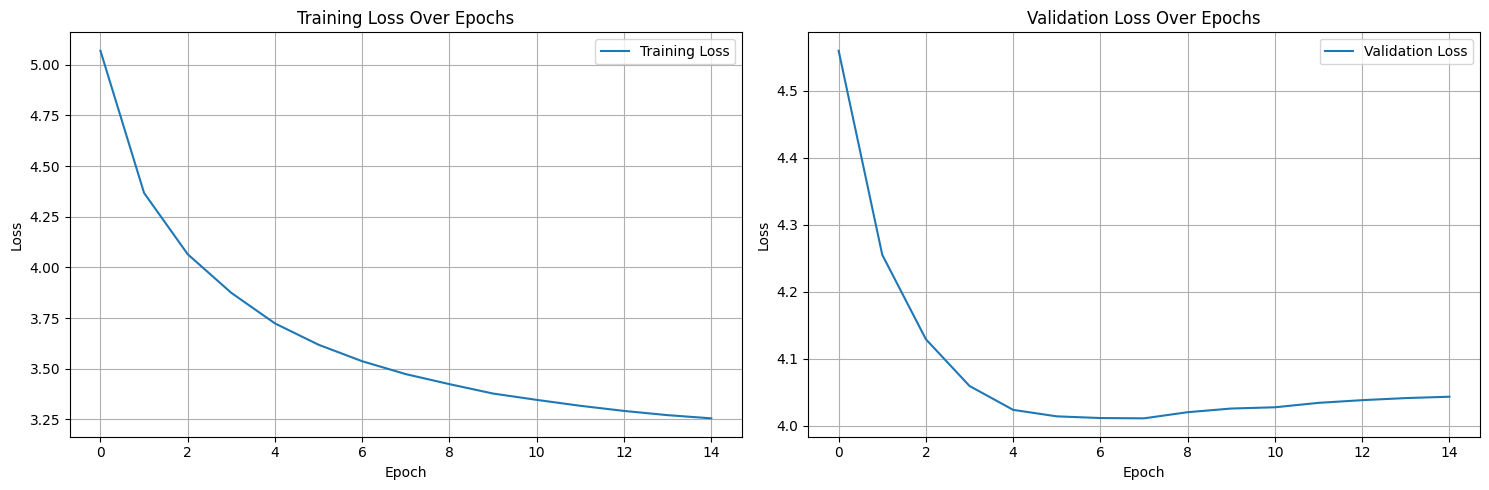

In [46]:
# Plot training history
plot_training_history(history)
    

In [47]:
# Print validation pairs and predictions
print("\nValidation Pairs vs Predictions:")
print("-" * 50)

evaluate_model(model, val_loader, device, dataset, BATCH_SIZE)
    



Validation Pairs vs Predictions:
--------------------------------------------------

Pair 1:
Context: ['school', 'what', 'class', '##e', 'w', '##e', '##r', '##e']
True word: ##s
Predicted: th
Correct: ✗

Pair 2:
Context: ['##e', '##ss', 'doubtful', 'towards', 'p', '##e', '##rson', 'about']
True word: that
Predicted: th
Correct: ✗

Pair 3:
Context: ['my', 'whol', '##e', 'lif', 'to', 'f', '##e', '##e']
True word: ##e
Predicted: ##e
Correct: ✓

Pair 4:
Context: ['i', 'was', 'th', '##e', '##e', 'to', 'f', '##e']
True word: ##r
Predicted: ##l
Correct: ✗

Pair 5:
Context: ['##e', '##n', 'your', '##e', 'out', 'but', 'th', '##e']
True word: working
Predicted: in
Correct: ✗

Pair 6:
Context: ['h', '##e', '##r', '##e', 'folks', 'ar', '##e', 'surpris']
True word: and
Predicted: ##e
Correct: ✗

Pair 7:
Context: ['##s', 'taking', 'quit', '##e', '##e', 'tim', '##e', '[PAD]']
True word: som
Predicted: th
Correct: ✗

Pair 8:
Context: ['##e', 'my', 'printing', 'class', '##s', 'at', 'quiltcon', 'partic

In [48]:
# Save final model and vocabulary

final_model_dir = 'final_model'

os.makedirs(final_model_dir, exist_ok=True)
    
save_vocabulary(final_model_dir, dataset)
save_model(final_model_dir, model, val_loss, accuracy)

## Cosine Similarity Triplets Part

In [49]:
# function to get triplets
def find_triplets(model: Word2VecModel, num_triplets: int = 2):
    triplets = []
    
    for i in range(num_triplets):
        # randomly choose an initial word index
        word_idx = torch.randint(0, model.vocab_size, (1,)).item()
        
        # get most similar words
        most_similar = model.find_most_similar(word_idx, top_k=2)
        
        # get the least similar word
        least_similar = model.find_least_similar(word_idx)
        
        # construct the triplet
        triplet = (word_idx, most_similar[0][0], most_similar[1][0], least_similar[0])
        triplets.append(triplet)
    
    return triplets



In [54]:
triplets = find_triplets(model)

print("Identified Triplets:")

for triplet in triplets:
    print(f"\nToken - {triplet[0]}\nSimilar tokens - {triplet[1]}, {triplet[2]}\nDissimilar token - {triplet[3]}")

    sim1 = model.cosine_similarity(triplet[0], triplet[1])
    sim2 = model.cosine_similarity(triplet[0], triplet[2])
    sim3 = model.cosine_similarity(triplet[0], triplet[3])

    print(f"Cosine similarity ({triplet[0]}, {triplet[1]}): {sim1}")
    print(f"Cosine similarity ({triplet[0]}, {triplet[2]}): {sim2}")
    print(f"Cosine similarity ({triplet[0]}, {triplet[3]}): {sim3}")


Identified Triplets:

Token - 1661
Similar tokens - 5874, 6122
Dissimilar token - 670
Cosine similarity (1661, 5874): 0.9563875198364258
Cosine similarity (1661, 6122): 0.9511027336120605
Cosine similarity (1661, 670): -0.8713014721870422

Token - 81
Similar tokens - 669, 1752
Dissimilar token - 6978
Cosine similarity (81, 669): 0.8902419805526733
Cosine similarity (81, 1752): 0.8819624185562134
Cosine similarity (81, 6978): -0.9065122604370117
